In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#!pip install yfinance
import yfinance as yf
from datetime import datetime
import pandas as pd
from numpy import concatenate
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

[*********************100%***********************]  1 of 1 completed


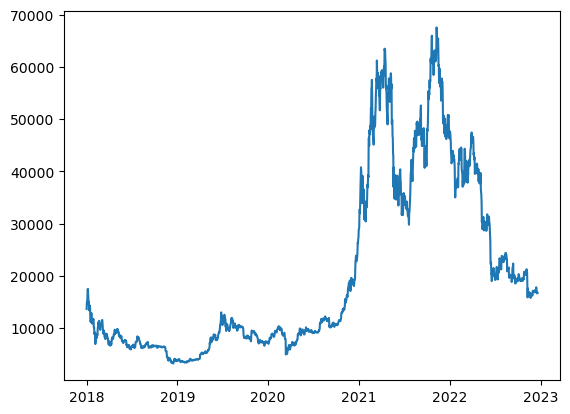

In [104]:
#data

today = datetime.today().strftime('%Y-%m-%d')
idx = pd.date_range('2018-01-01', today)

df_A = yf.download("BTC-USD", start="2018-01-01", end=today)["Close"]
df_A = df_A.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_A)

In [105]:
timeseries = pd.concat([df_A], axis=1)
timeseries.columns = (["close-btc"])
#timeseries["close-btc-out"] = timeseries["close-btc"].shift(-1)
timeseries.head()

,close-btc
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


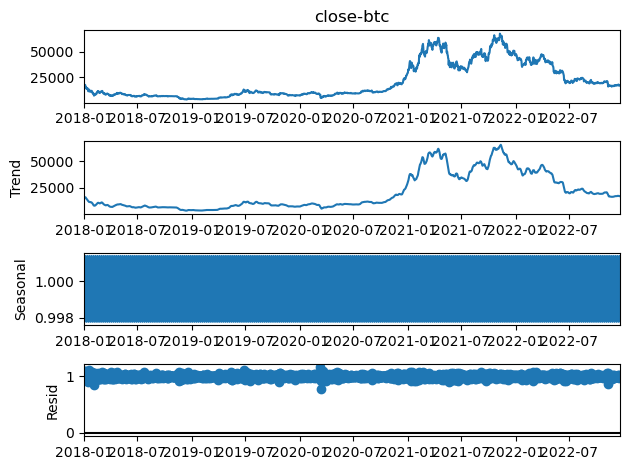

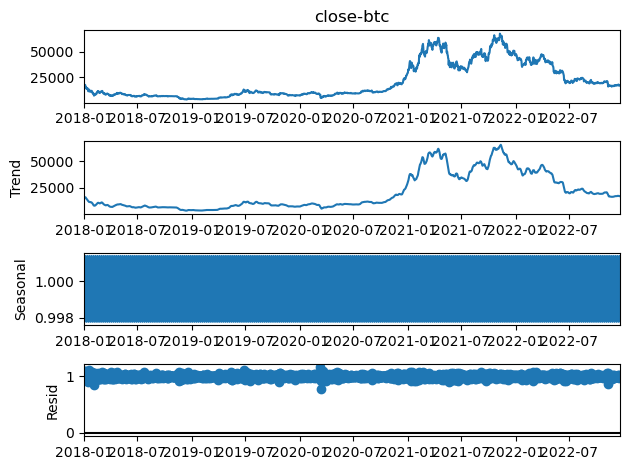

In [106]:
# ETS Decomposition
result = seasonal_decompose(timeseries['close-btc'], 
                            model ='multiplicative')
  
# ETS plot 
result.plot()

In [107]:
scaler = MinMaxScaler()
timeseries = timeseries["close-btc"].values.reshape(timeseries.shape[0],1)
print(timeseries)
timeseries = scaler.fit_transform(timeseries)

[[13657.20019531]
 [14982.09960938]
 [15201.        ]
 ...
 [16795.09179688]
 [16757.9765625 ]
 [16757.9765625 ]]


In [108]:
# Split data into train / test sets
train = timeseries[:len(timeseries)-1200]
test = timeseries[len(timeseries)-1200:] # set one year(12 months) for testing
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train, 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.53360D+00    |proj g|=  3.90013D+01



 This problem is unconstrained.


At iterate    5    f= -3.56148D+00    |proj g|=  1.46219D-01

At iterate   10    f= -3.56288D+00    |proj g|=  1.51898D+01

At iterate   15    f= -3.58465D+00    |proj g|=  5.21443D-01

At iterate   20    f= -3.58524D+00    |proj g|=  5.08662D+00

At iterate   25    f= -3.59794D+00    |proj g|=  5.08643D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     54      1     0     0   9.681D-01  -3.601D+00
  F =  -3.6012148123136583     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  614
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                2211.146
Date:                            Mon, 19 Dec 2022   AIC                          -4412.292
Time:                                    15:59:54   BIC                          -4390.299
Sample:                                         0   HQIC                         -4403.731
                                            - 614                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0371      0.024     -1.515      0.130      -0.085       0.011
ar.S.L12      -0.1454      0.045     -3.218      0.001      -0.234      -0.057
ar.S.L24      -0.2873      0.035     -8.186      0.000      -0.356      -0.219
ma.S.L12      -0.6880      0.051    -13.468      0.000      -0.788      -0.588
sigma2      3.655e-05   1.27e-06     28.865      0.000    3.41e-05     3.9e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):               730.10
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

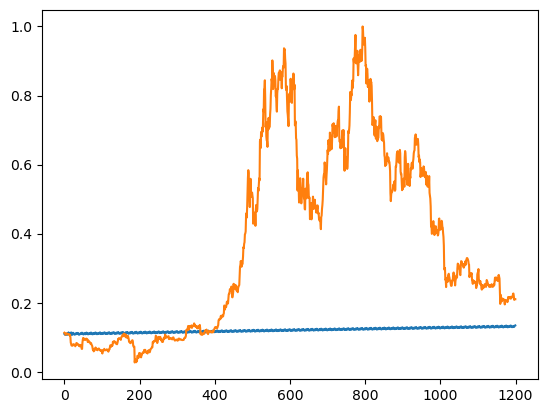

In [109]:
start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end, typ = 'levels')
  
# plot predictions and actual values
plt.plot(predictions)
plt.plot(test)

In [110]:
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
rmse(test, predictions)
  
# Calculate mean squared error
mean_squared_error(test, predictions)

0.13385077899719913

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.54921D+00    |proj g|=  1.84518D+01

At iterate    5    f= -2.61335D+00    |proj g|=  7.60326D-01

At iterate   10    f= -2.62316D+00    |proj g|=  5.89288D+00

At iterate   15    f= -2.62605D+00    |proj g|=  1.04619D-01

At iterate   20    f= -2.62720D+00    |proj g|=  2.25609D+00

At iterate   25    f= -2.64793D+00    |proj g|=  3.63152D+00

At iterate   30    f= -2.65746D+00    |proj g|=  7.90072D-01

At iterate   35    f= -2.68400D+00    |proj g|=  2.01873D+00

At iterate   40    f= -2.69958D+00    |proj g|=  2.95671D-01

At iterate   45    f= -2.70026D+00    |proj g|=  8.44039D-02


/Users/a125x/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.70152D+00    |proj g|=  3.33646D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   3.336D-02  -2.702D+00
  F =  -2.7015175534093148     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


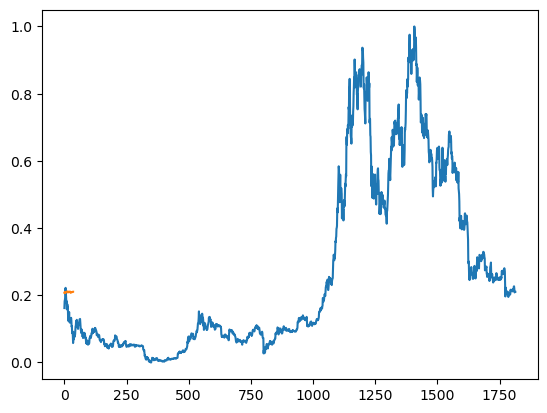

In [111]:
# Train the model on the full dataset
model = model = SARIMAX(timeseries, 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(timeseries), 
                          end = (len(timeseries)-1) + 3 * 12, 
                          typ = 'levels')
  
# Plot the forecast values
plt.plot(timeseries)
plt.plot(forecast)